# Importign required modules

In [20]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [21]:
# Train transformations
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

# Test transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])


In [22]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [23]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

SEED = 1
# To reproduce the same results across the sessions
torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)
  dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True)
else:
  dataloader_args = dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Model

In [24]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
        ) # output_size = 26


        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
        ) # output_size = 24


        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12


        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
        ) # output_size = 10

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
        ) # output_size = 8

        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 4

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 2


        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=2)
        ) # output_size = 1

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.pool2(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = self.convblock7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [25]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4            [-1, 8, 24, 24]             576
              ReLU-5            [-1, 8, 24, 24]               0
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
            Conv2d-8            [-1, 8, 24, 24]             576
              ReLU-9            [-1, 8, 24, 24]               0
      BatchNorm2d-10            [-1, 8, 24, 24]              16
        MaxPool2d-11            [-1, 8, 12, 12]               0
           Conv2d-12           [-1, 16, 10, 10]           1,152
             ReLU-13           [-1, 16, 10, 10]               0
      BatchNorm2d-14           [-1, 16,

In [26]:
from tqdm import tqdm

# Aggregate loss and accuracy
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)

  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    # get batch data
    data, target = data.to(device), target.to(device)

    # Reset all gradients to zero
    optimizer.zero_grad()

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Do calculate the grads in dackpropagation
    loss.backward()

    # Update the model weights
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Aggregate batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Update total test data loss
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Training & Testing

In [27]:
# Creat the mode and move it to CUDA
model = Net().to(device)

# Using stochastic gradient descent method for optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 15
for epoch in range(EPOCHS):
    print(f"EPOCH: {epoch}")
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.042479563504457474 Batch_id=468 Accuracy=93.34: 100%|██████████| 469/469 [00:28<00:00, 16.60it/s]



Test set: Average loss: 0.0726, Accuracy: 9791/10000 (97.91%)

EPOCH: 1


Loss=0.03590460494160652 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:21<00:00, 21.81it/s]



Test set: Average loss: 0.0385, Accuracy: 9892/10000 (98.92%)

EPOCH: 2


Loss=0.058084141463041306 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:20<00:00, 22.57it/s]



Test set: Average loss: 0.0374, Accuracy: 9886/10000 (98.86%)

EPOCH: 3


Loss=0.02596624195575714 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:20<00:00, 22.37it/s]



Test set: Average loss: 0.0339, Accuracy: 9893/10000 (98.93%)

EPOCH: 4


Loss=0.04204963147640228 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:21<00:00, 22.07it/s]



Test set: Average loss: 0.0291, Accuracy: 9909/10000 (99.09%)

EPOCH: 5


Loss=0.022579096257686615 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:21<00:00, 21.51it/s]



Test set: Average loss: 0.0262, Accuracy: 9924/10000 (99.24%)

EPOCH: 6


Loss=0.008613639511168003 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:22<00:00, 20.70it/s]



Test set: Average loss: 0.0241, Accuracy: 9929/10000 (99.29%)

EPOCH: 7


Loss=0.04520199075341225 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:22<00:00, 21.25it/s]



Test set: Average loss: 0.0216, Accuracy: 9935/10000 (99.35%)

EPOCH: 8


Loss=0.029276810586452484 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:21<00:00, 22.33it/s]



Test set: Average loss: 0.0256, Accuracy: 9917/10000 (99.17%)

EPOCH: 9


Loss=0.02774013765156269 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:20<00:00, 22.46it/s]



Test set: Average loss: 0.0219, Accuracy: 9931/10000 (99.31%)

EPOCH: 10


Loss=0.012518689967691898 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:20<00:00, 22.36it/s]



Test set: Average loss: 0.0219, Accuracy: 9931/10000 (99.31%)

EPOCH: 11


Loss=0.03581111133098602 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:22<00:00, 21.24it/s]



Test set: Average loss: 0.0206, Accuracy: 9933/10000 (99.33%)

EPOCH: 12


Loss=0.010190446861088276 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:22<00:00, 21.06it/s]



Test set: Average loss: 0.0239, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.016952065750956535 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:22<00:00, 20.53it/s]



Test set: Average loss: 0.0219, Accuracy: 9924/10000 (99.24%)

EPOCH: 14


Loss=0.0026959218084812164 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:22<00:00, 20.80it/s]



Test set: Average loss: 0.0197, Accuracy: 9933/10000 (99.33%)



Text(0.5, 1.0, 'Test Accuracy')

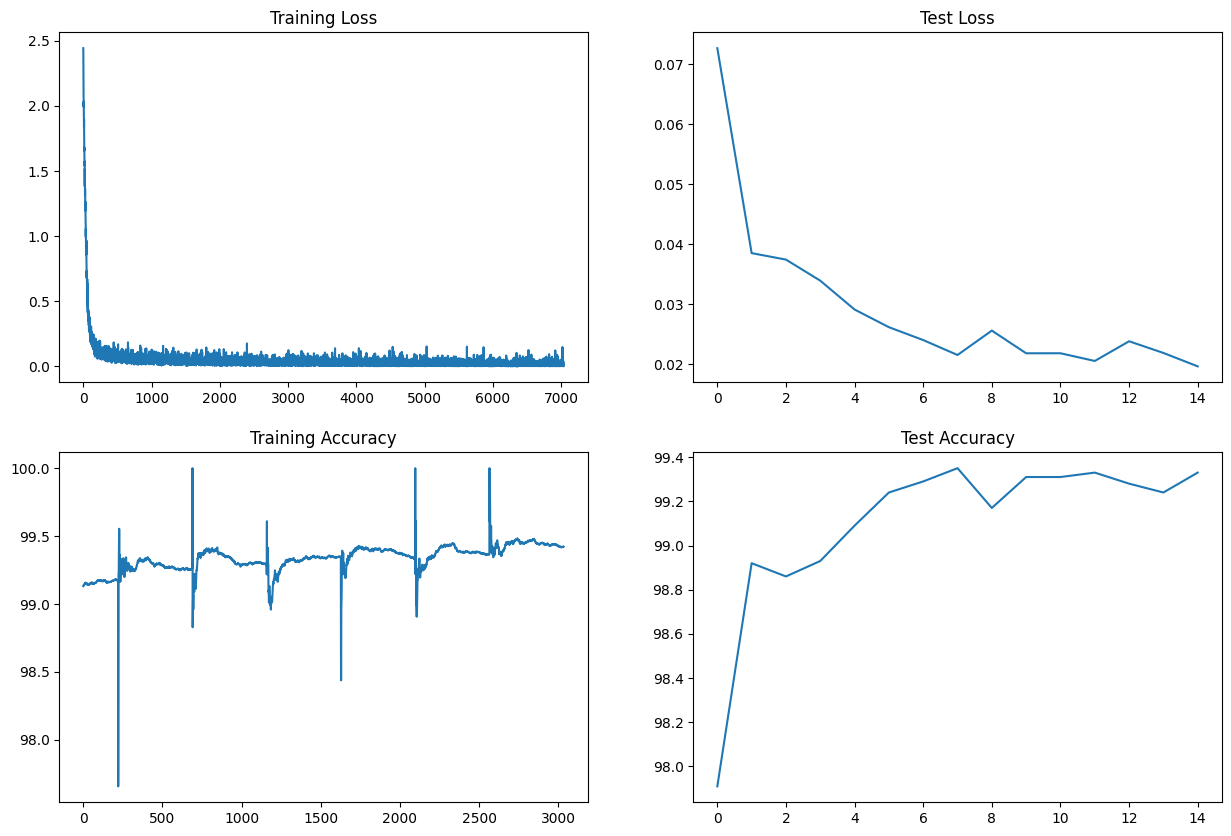

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

t = [t_items.item() for t_items in train_losses]

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Iteration 2
---
## Target:
*   Applying 'Batch-normalization' for each layer
*   Applying 'Dropout' to reduce overfitting. Applied only at selected location

## Results:
*   Total params: 7,288
*   Best Training Accuracy: 99.42%
*   Best Test Accuracy: 99.35% (Epoch 7)

## Analysis:
*   Applied dropouts randomly only at two locations with a learning rate of 0.1.
*   Both the test and training accuracies improved, although the test accuracy is still slightly below the targeted value.
*   The highest test accuracy in this iteration was achieved in the 7th epoch. However, it failed to reach the target value.
